In [2]:
import pandas as pd
import numpy as np
import netCDF4 as nc
import os
import xarray as xr
import datetime

In [4]:
class dataset_reshape:
    def __init__(self,path_Cl,path_Ct,path_Sl,path_St):
        self.path_Cl = path_Cl
        self.path_Ct= path_Ct
        self.path_Sl=path_Sl
        self.path_St=path_St
    def trans(x):
        temp=10000*(6-(x>2265))+(x<2266)*((x-1)//151+1)+(x>2265)*(((x-1)-2265)//140+1)#这里返回str报错
        #<2266:CMIP6 >2265:CMIP5
        #编码顺序开始5，6，1表示CMIP5,6,SODA 后面表示模式 从1计数 
        return temp
    def transyear(x):#因为遍历规则，不能对X比较大小 报错ambiguous
        temp=(x<2266)*((x-1)%151+1)+(x>2265)*((x-1-2265)%140+1)#年份的顺序，计数从1开始
        return temp
    def data_set(self):
        A=nc.Dataset(self.path_Cl)
        A= xr.open_dataset(xr.backends.NetCDF4DataStore(A))
        B=nc.Dataset(self.path_Ct)
        B= xr.open_dataset(xr.backends.NetCDF4DataStore(B))
        CMIP=B
        CMIP['nino']=(('year','month'),A['nino'])
        CMIP=CMIP.drop_sel(month=np.arange(13,37))
        CMIPdf=CMIP.to_dataframe()
        CMIPdf=CMIPdf.reset_index()
        CMIPdf['mode']=CMIPdf['year'].apply(dataset_reshape.trans)
        CMIPdf['year']=CMIPdf['year'].apply(dataset_reshape.transyear)
        CMIPdf['time']=CMIPdf.year*12+CMIPdf.month-12
        C=nc.Dataset(self.path_St)
        C= xr.open_dataset(xr.backends.NetCDF4DataStore(C))
        D=nc.Dataset(self.path_Sl)
        D= xr.open_dataset(xr.backends.NetCDF4DataStore(D))
        SODA=C
        SODA['nino']=(('year','month'),D.nino)
        SODA=SODA.drop_sel(month=np.arange(13,37))
        SODAdf=SODA.to_dataframe()
        SODAdf=SODAdf.reset_index()
        SODAdf['mode']=10000
        SODAdf['time']=SODAdf.year*12+SODAdf.month-12
        data=pd.concat([CMIPdf, SODAdf])
        data_reindex=data.set_index(['lat', 'lon','month','year','mode'])
        data_set=xr.Dataset.from_dataframe(data_reindex)
        return(data_set)
    def data_frame(self,train_data):#data_set转换为dataframe且把不同模式多余年份删除
        train=train_data.to_dataframe()
        train=train.reset_index()
        df = train.drop(train[(train['mode']< 20000)&(train.year>100)].index)
        df=df.drop(df[(df['mode']//10000==5)&(df.year>140)].index)
        return(df)
    def delete_mode(self,df):#删除有缺失值的mode
        dfnona=df[df['mode']!=60013]
        for i in np.arange(60006,60010):
            dfnona=dfnona[(dfnona['mode']!=i)]
        return dfnona

In [7]:
train_dir = '../tcdata/enso_round1_train_20210201'
path_train=[]
for i in os.listdir(train_dir):
    if i.endswith('.nc'):path_train.append(train_dir + '/' + i)
data=dataset_reshape(path_train[0],path_train[1],path_train[2],path_train[3])

In [10]:
path_train

['../tcdata/enso_round1_train_20210201/CMIP_label.nc',
 '../tcdata/enso_round1_train_20210201/CMIP_train.nc',
 '../tcdata/enso_round1_train_20210201/SODA_label.nc',
 '../tcdata/enso_round1_train_20210201/SODA_train.nc']

In [ ]:
train_data=data.data_set()

In [8]:
df=data.data_frame(train_data)#24*72

NameError: name 'train_data' is not defined

In [422]:
#dfnona[(dfnona['mode']==50012)&(dfnona.year==1)&(dfnona.month==1)].reset_index()

,index,lat,lon,mode,month,year,sst,t300,ua,va,nino,time,ua_ma,va_ma
0,21744,-55.0,0.0,50012,1,1,-0.173560,0.138304,-0.693266,-0.361689,0.229419,1.0,0.741687,-0.081531
1,81540,-55.0,5.0,50012,1,1,-0.193518,0.147095,-0.892133,-0.215576,0.229419,1.0,0.669252,0.114693
2,141336,-55.0,10.0,50012,1,1,-0.175659,0.152401,-1.282962,0.448194,0.229419,1.0,0.348245,0.444278
3,201132,-55.0,15.0,50012,1,1,-0.177245,0.120873,-1.583398,1.557913,0.229419,1.0,0.360193,1.182769
4,260928,-55.0,20.0,50012,1,1,-0.133627,0.092032,-1.774697,2.153725,0.229419,1.0,0.457004,1.769547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,103050252,60.0,335.0,50012,1,1,0.403590,0.355417,-6.413555,-0.342856,0.229419,1.0,-2.340838,-0.627950
1724,103110048,60.0,340.0,50012,1,1,0.168970,0.155346,-6.232862,-1.263438,0.229419,1.0,-2.381048,-0.326538
1725,103169844,60.0,345.0,50012,1,1,0.047110,0.043196,-5.810275,-1.269838,0.229419,1.0,-2.840842,-0.132182
1726,103229640,60.0,350.0,50012,1,1,0.065001,0.072970,-4.709105,-1.204750,0.229419,1.0,-2.641346,-0.691324


In [425]:
map_mean=dfnona.groupby(['year','month','mode']).mean()

In [444]:
map_mean=map_mean.swaplevel(0,2)

In [450]:
map_mean=map_mean.swaplevel(1,2)

In [509]:
modes=set(dfnona['mode'].values)

for i in modes:
    temp=map_mean.loc[i].reset_index()
    plt.hist(temp['nino'], bins=100)
    plt.title(i)
    plt.savefig('fig/'+str(i))
    plt.show()

In [459]:
mean10000=map_mean.loc[10000].reset_index()

In [465]:
ua_ma=mean10000.ua.rolling(3).mean()
mean10000['ua_ma']=ua_ma.bfill()
va_ma=mean10000.va.rolling(3).mean()
mean10000['va_ma']=va_ma.bfill()

/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


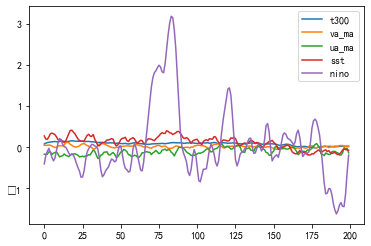

In [482]:
mean10000[:200][['t300','va_ma','ua_ma','sst','nino']].plot()

In [513]:
mean10000[['nino','t300','sst','ua','va']].corr()

,nino,t300,sst,ua,va
nino,1.000000,0.032457,0.272875,0.186554,-0.039051
t300,0.032457,1.000000,0.839486,-0.300959,0.234216
sst,0.272875,0.839486,1.000000,-0.138612,0.152600
ua,0.186554,-0.300959,-0.138612,1.000000,-0.147240
va,-0.039051,0.234216,0.152600,-0.147240,1.000000


In [415]:
#df=df.sort_values(by=['year','month'],axis=0,ascending=[True,True]) 

In [420]:
#df.reset_index()

,index,lat,lon,mode,month,year,sst,t300,ua,va,nino,time
0,0,-55.0,0.0,10000,1,1,1.861851,0.374280,0.429292,0.087189,-0.407207,1.0
1,1812,-55.0,0.0,50001,1,1,-0.349272,-0.704941,-2.984014,0.079515,-1.910325,1.0
2,3624,-55.0,0.0,50002,1,1,-0.559291,-0.282150,-0.874612,0.053287,0.613110,1.0
3,5436,-55.0,0.0,50003,1,1,-0.679301,-0.042049,0.601715,0.231112,0.170669,1.0
4,7248,-55.0,0.0,50004,1,1,1.042597,0.251659,-2.910398,0.082064,1.370985,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
98392315,103320239,60.0,355.0,60011,12,151,0.610248,0.610800,-3.742297,-2.055270,0.408104,1812.0
98392316,103322051,60.0,355.0,60012,12,151,0.456476,0.618580,1.525600,-4.281870,0.144029,1812.0
98392317,103323863,60.0,355.0,60013,12,151,0.460298,0.464208,-5.728569,5.944243,0.219541,1812.0
98392318,103325675,60.0,355.0,60014,12,151,-0.098747,-0.089735,1.682719,5.249362,0.141294,1812.0


In [393]:
for i in np.arange(6,10):print(i)

6
7
8
9


In [267]:
# [60006,60007,60008,60009,60013]
dfnona=df[df['mode']!=60013]
for i in np.arange(60006,60010):
    dfnona=dfnona[(dfnona['mode']!=i)]

In [414]:
#这个的顺序有问题ww
ua_ma=dfnona.ua.rolling(3).mean()
dfnona['ua_ma']=ua_ma.bfill()
va_ma=dfnona.va.rolling(3).mean()
dfnona['va_ma']=va_ma.bfill()

,lat,lon,mode,month,year,sst,t300,ua,va,nino,time,ua_ma,va_ma
0,-55.0,0.0,10000,1,1,1.861851,0.374280,0.429292,0.087189,-0.407207,1.0,0.825691,-0.409390
1,-55.0,0.0,10000,1,2,-0.272264,0.062039,2.033018,-0.978357,0.066972,13.0,0.825691,-0.409390
2,-55.0,0.0,10000,1,3,0.029107,0.023624,0.014763,-0.337003,-0.732018,25.0,0.825691,-0.409390
3,-55.0,0.0,10000,1,4,0.116086,0.002191,-0.779131,0.283343,-0.259308,37.0,0.422883,-0.344006
4,-55.0,0.0,10000,1,5,-0.303765,-0.017604,0.718747,0.432904,-0.123334,49.0,-0.015207,0.126415
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103327483,60.0,355.0,60015,12,147,0.042211,0.078373,2.717890,-2.327800,0.127306,1764.0,-0.572082,-1.529823
103327484,60.0,355.0,60015,12,148,0.243439,0.213340,-0.061371,1.927317,-1.288491,1776.0,-0.257610,-0.729354
103327485,60.0,355.0,60015,12,149,0.003961,0.015906,2.402917,1.884017,-1.729616,1788.0,1.686478,0.494511
103327486,60.0,355.0,60015,12,150,0.364674,0.299690,-1.998595,3.431924,-0.506560,1800.0,0.114317,2.414419


In [412]:
dfnona.corr()

,lat,lon,mode,month,year,sst,t300,ua,va,nino,time
lat,1.000000e+00,0.000000e+00,1.899359e-20,0.000000e+00,9.948359e-21,0.015836,0.016921,0.000189,-0.000226,9.719468e-21,-2.349710e-21
lon,0.000000e+00,1.000000e+00,4.553003e-20,0.000000e+00,-1.280193e-19,-0.019655,-0.013865,-0.000069,0.000066,-4.018782e-19,1.712575e-19
mode,1.899359e-20,4.553003e-20,1.000000e+00,1.240370e-21,1.045479e-01,-0.097086,-0.087135,0.000088,-0.000101,-1.056059e-01,1.045455e-01
month,0.000000e+00,0.000000e+00,1.240370e-21,1.000000e+00,1.607262e-16,-0.001553,-0.001844,-0.000002,-0.000053,-1.464622e-03,6.909883e-03
year,9.948359e-21,-1.280193e-19,1.045479e-01,1.607262e-16,1.000000e+00,0.130297,0.108841,0.004411,-0.003019,1.596097e-01,9.999761e-01
sst,1.583557e-02,-1.965522e-02,-9.708609e-02,-1.553178e-03,1.302966e-01,1.000000,0.644064,-0.041805,-0.010443,1.410705e-01,1.302828e-01
t300,1.692128e-02,-1.386534e-02,-8.713509e-02,-1.844114e-03,1.088406e-01,0.644064,1.000000,-0.031940,0.000824,9.318405e-02,1.088252e-01
ua,1.886179e-04,-6.856754e-05,8.811426e-05,-2.369821e-06,4.411451e-03,-0.041805,-0.031940,1.000000,0.003291,1.046707e-02,4.411330e-03
va,-2.260921e-04,6.559182e-05,-1.012872e-04,-5.332450e-05,-3.018771e-03,-0.010443,0.000824,0.003291,1.000000,3.017346e-04,-3.019067e-03
nino,9.719468e-21,-4.018782e-19,-1.056059e-01,-1.464622e-03,1.596097e-01,0.141070,0.093184,0.010467,0.000302,1.000000e+00,1.595958e-01


In [ ]:
import statsmodels.api as sm
#多元线性回归
reg_model = sm.OLS(dfnona['nino'], sm.add_constant(dfnona.iloc[:, 5:9])).fit()

In [270]:
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   nino   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                 4.260e+05
Date:                Thu, 25 Feb 2021   Prob (F-statistic):               0.00
Time:                        14:29:59   Log-Likelihood:            -9.8863e+07
No. Observations:            82736640   AIC:                         1.977e+08
Df Residuals:                82736635   BIC:                         1.977e+08
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0965   8.86e-05  -1088.856      0.0

In [282]:
import matplotlib
import matplotlib.pyplot as plt

/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


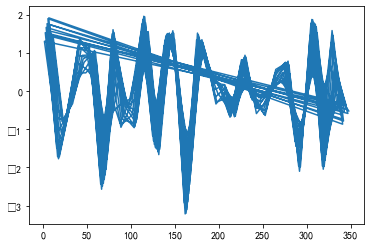

In [394]:
x=df[(df['mode']==50012)&(df.lat==-55)&(df.lon==355)&(df.year<30)]['time']
y=df[(df['mode']==50012)&(df.lat==-55)&(df.lon==355)&(df.year<30)]['nino'].diff()
plt.plot(x,y)

In [331]:
C5=df[(df['mode']==50012)&(df.lat==-55)&(df.lon==355)&(df.year<20)][['nino','time']].sort_values("time")
SO=df[(df['mode']==10000)&(df.lat==-55)&(df.lon==355)&(df.year<20)][['nino','time']].sort_values("time")
C6=df[(df['mode']==60012)&(df.lat==-55)&(df.lon==355)&(df.year<20)][['nino','time']].sort_values("time")

In [345]:
x=C5['nino'].values
y=SO['nino'].values
z=C6['nino'].values
modenino=pd.DataFrame({'CMIP5':x,'SODA':y,'CMIP6':z})
modenino

,CMIP5,SODA,CMIP6
0,0.229419,-0.407207,-1.175907
1,0.471351,-0.202444,-1.276108
2,0.751270,-0.103861,-1.311295
3,0.981141,-0.029108,-1.399331
4,1.132148,-0.132530,-1.246896
...,...,...,...
223,0.086300,-1.273308,-0.759946
224,0.245698,-1.359125,-0.772757
225,0.335151,-1.622333,-0.822704
226,0.336135,-1.847443,-0.801696


/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


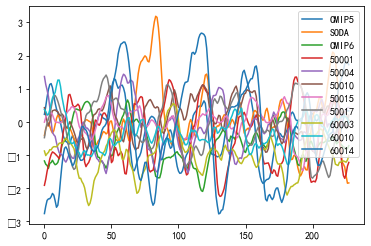

In [395]:
modenino.plot()

In [347]:
modelist=[50001,50004,50010,50015,50017,60003,60010,60014]
for i in modelist:
    temp=df[(df['mode']==i)&(df.lat==-55)&(df.lon==355)&(df.year<20)][['nino','time']].sort_values("time")
    temp2=temp['nino'].values
    modenino[str(i)]=temp2

/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


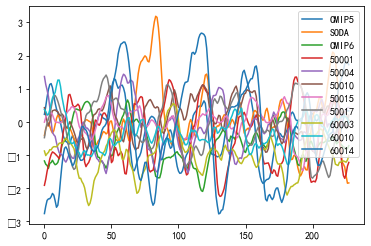

In [348]:
modenino.plot()

In [356]:
C5_12=df[(df['mode']==50001)&(df.lat==-55)&(df.lon==355)&(df.year<6)][['nino','time','month']].sort_values("time")
C5_12['season']=C5_12['month'].apply(lambda x:x//4)
reg_model2 = sm.OLS(C5_12['nino'], C5_12['season']).fit()
reg_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   nino   R-squared (uncentered):                   0.195
Model:                            OLS   Adj. R-squared (uncentered):              0.181
Method:                 Least Squares   F-statistic:                              14.26
Date:                Thu, 25 Feb 2021   Prob (F-statistic):                    0.000372
Time:                        23:16:05   Log-Likelihood:                         -69.700
No. Observations:                  60   AIC:                                      141.4
Df Residuals:                      59   BIC:                                      143.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season        -0.2445      0.065     -3.776      0.000      -0.374      -0.115
==============================================================================
Omnibus:                        1.406   Durbin-Watson:                   0.158
Prob(Omnibus):                  0.495   Jarque-Bera (JB):                1.165
Skew:                           0.134   Prob(JB):                        0.559
Kurtosis:                       2.372   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [357]:
C5_12=df[(df['mode']==50001)&(df.lat==-55)&(df.lon==355)&(df.year<6)][['nino','sst','time','month']].sort_values("time")
C5_12['season']=C5_12['month'].apply(lambda x:x//4)
reg_model2 = sm.OLS(C5_12['sst'], C5_12['season']).fit()
reg_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    sst   R-squared (uncentered):                   0.502
Model:                            OLS   Adj. R-squared (uncentered):              0.493
Method:                 Least Squares   F-statistic:                              59.44
Date:                Thu, 25 Feb 2021   Prob (F-statistic):                    1.70e-10
Time:                        23:16:49   Log-Likelihood:                         -50.111
No. Observations:                  60   AIC:                                      102.2
Df Residuals:                      59   BIC:                                      104.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season        -0.3601      0.047     -7.709      0.000      -0.454      -0.267
==============================================================================
Omnibus:                        0.007   Durbin-Watson:                   0.669
Prob(Omnibus):                  0.997   Jarque-Bera (JB):                0.139
Skew:                           0.015   Prob(JB):                        0.933
Kurtosis:                       2.766   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [388]:
C5_12=df[(df['mode']==50001)&(df.lat==-55)&(df.lon==355)&(df.year<6)][['nino','t300','sst','time','month']].sort_values("time")
C5_12['season']=C5_12['month'].apply(lambda x:x//4)
reg_model2 = sm.OLS(C5_12['t300'], C5_12['season']).fit()
reg_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   t300   R-squared (uncentered):                   0.580
Model:                            OLS   Adj. R-squared (uncentered):              0.572
Method:                 Least Squares   F-statistic:                              81.32
Date:                Thu, 25 Feb 2021   Prob (F-statistic):                    1.07e-12
Time:                        23:22:36   Log-Likelihood:                         -22.495
No. Observations:                  60   AIC:                                      46.99
Df Residuals:                      59   BIC:                                      49.08
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season        -0.2659      0.029     -9.018      0.000      -0.325      -0.207
==============================================================================
Omnibus:                        1.221   Durbin-Watson:                   0.506
Prob(Omnibus):                  0.543   Jarque-Bera (JB):                1.023
Skew:                          -0.071   Prob(JB):                        0.600
Kurtosis:                       2.376   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [362]:
C5_12=df[(df['mode']==50001)&(df.lat==-55)&(df.lon==355)&(df.year<30)][['nino','t300','ua','va','sst','time','month']].sort_values("time")
C5_12['season']=C5_12['month'].apply(lambda x:x//4)
reg_model2 = sm.OLS(C5_12['va'], C5_12['season']).fit()
reg_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     va   R-squared (uncentered):                   0.018
Model:                            OLS   Adj. R-squared (uncentered):              0.016
Method:                 Least Squares   F-statistic:                              6.494
Date:                Thu, 25 Feb 2021   Prob (F-statistic):                      0.0113
Time:                        23:18:12   Log-Likelihood:                         -582.34
No. Observations:                 348   AIC:                                      1167.
Df Residuals:                     347   BIC:                                      1171.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season        -0.1135      0.045     -2.548      0.011      -0.201      -0.026
==============================================================================
Omnibus:                        0.811   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.667   Jarque-Bera (JB):                0.913
Skew:                           0.068   Prob(JB):                        0.634
Kurtosis:                       2.789   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [315]:
C5all=df[(df['mode']==50012)&(df.lat==-55)&(df.lon==355)&(df.year<10)][['nino','time','sst','t300','ua','va']].sort_values("time")

In [410]:
x=C5all['nino'].values
y=C5all['sst'].values
z=C5all['t300'].values
w=C5all['ua'].values
v=C5all['va'].values
modenino=pd.DataFrame({'nino':x,'sst':y,'t300':z,'ua':w,'va':v})
modenino

,nino,sst,t300,ua,va
0,0.229419,-0.270299,0.183858,-0.815802,-0.079985
1,0.471351,-0.285073,0.187045,0.384598,-0.334995
2,0.751270,-0.235127,0.183783,-0.140491,1.443268
3,0.981141,-0.201489,0.173010,-2.976624,0.725737
4,1.132148,-0.025268,0.191217,-0.706932,-0.744204
...,...,...,...,...,...
103,-1.467375,-0.009539,0.012327,-0.805254,1.483542
104,-1.308769,0.163510,0.055328,1.974212,-0.675304
105,-1.094677,0.237647,0.081086,2.075076,1.509920
106,-0.988632,0.247238,0.076264,1.951017,2.490382


/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


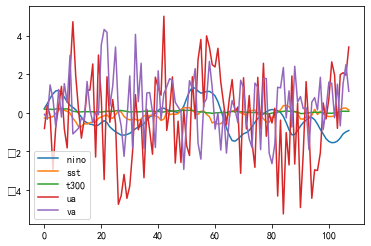

In [411]:
modenino.plot()

In [327]:
C6all=df[(df['mode']==60012)&(df.lat==-55)&(df.lon==355)&(df.year<10)][['nino','time','sst','t300','ua','va']].sort_values("time")

/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


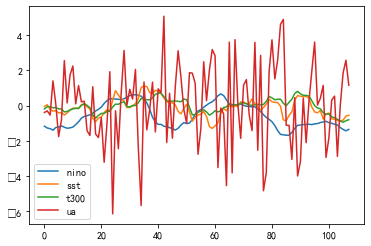

In [328]:
x=C6all['nino'].values
y=C6all['sst'].values
z=C6all['t300'].values
w=C6all['ua'].values
modenino=pd.DataFrame({'nino':x,'sst':y,'t300':z,'ua':w})
modenino.plot()

In [329]:
Nall=df[(df['mode']==10000)&(df.lat==-55)&(df.lon==355)&(df.year<10)][['nino','time','sst','t300','ua','va']].sort_values("time")

/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


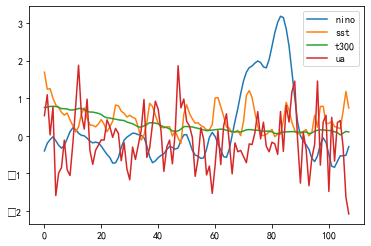

In [330]:
x=Nall['nino'].values
y=Nall['sst'].values
z=Nall['t300'].values
w=Nall['ua'].values
modenino=pd.DataFrame({'nino':x,'sst':y,'t300':z,'ua':w})
modenino.plot()

/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


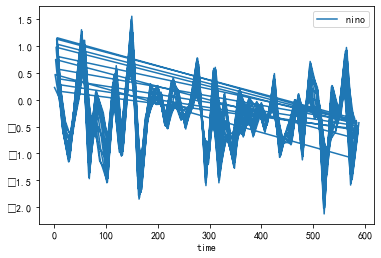

In [286]:
df[(df['mode']==50012)&(df.lat==-55)&(df.lon==355)&(df.year<50)].plot(x="time", y="nino")

In [ ]:
df[(df['mode']==50012)&(df.lat==-55)&(df.lon==355)&(df.year<20)].plot.scatter(x="time", y="nino")

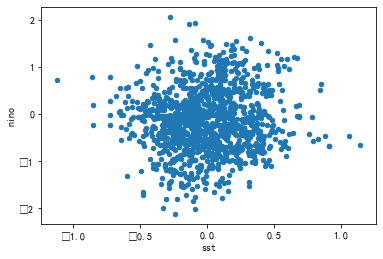

In [277]:
df[(df['mode']==50012)&(df.lat==-55)&(df.lon==355)&(df.year<100)].plot.scatter(x="sst", y="nino")

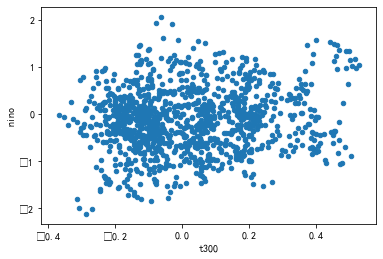

In [279]:
df[(df['mode']==50012)&(df.lat==-55)&(df.lon==355)&(df.year<100)].plot.scatter(x="t300", y="nino")

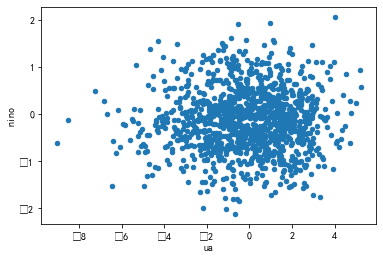

In [280]:
df[(df['mode']==50012)&(df.lat==-55)&(df.lon==355)&(df.year<100)].plot.scatter(x="ua", y="nino")

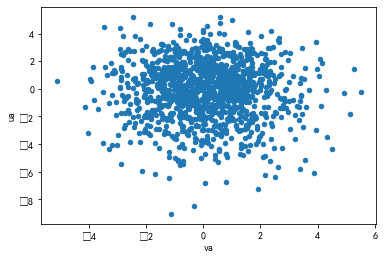

In [281]:
df[(df['mode']==50012)&(df.lat==-55)&(df.lon==355)&(df.year<100)].plot.scatter(x="va", y="ua")

In [266]:
dfnona[dfnona.t300.isna()]['mode'].value_counts()

60013    1018344
Name: mode, dtype: int64

# History draft

In [130]:
#train_data['t300'].isnull()

In [131]:
train=train_data.to_dataframe()
train=train.reset_index()

In [132]:
df = train.drop(train[(train['mode']< 20000)&(train.year>100)].index)

In [133]:
df=df.drop(df[(df['mode']//10000==5)&(df.year>140)].index)

In [180]:
df=data.data_frame(train_data)
df

AttributeError: 'dataset_reshape' object has no attribute 'data_frame'

In [134]:
SODA=df[df['mode']==10000]

In [135]:
SODA.isna().mean()

lat      0.0
lon      0.0
mode     0.0
month    0.0
year     0.0
sst      0.0
t300     0.0
ua       0.0
va       0.0
nino     0.0
time     0.0
dtype: float64

In [136]:
CMIP5=df[df['mode']//10000==5]

In [137]:
CMIP5.isna().mean()

lat      0.0
lon      0.0
mode     0.0
month    0.0
year     0.0
sst      0.0
t300     0.0
ua       0.0
va       0.0
nino     0.0
time     0.0
dtype: float64

In [138]:
CMIP6=df[df['mode']//10000==6]
CMIP6.isna().mean()

lat      0.000000
lon      0.000000
mode     0.000000
month    0.000000
year     0.000000
sst      0.000000
t300     0.021682
ua       0.098803
va       0.098803
nino     0.000000
time     0.000000
dtype: float64

In [153]:
t300na=CMIP6[CMIP6.t300.isna()]
t300na

,lat,lon,mode,month,year,sst,t300,ua,va,nino,time
3522528,-55.0,290.0,60013,1,1,0.431578,NaN,NaN,NaN,0.397166,1.0
3522529,-55.0,290.0,60013,1,2,0.477347,NaN,NaN,NaN,-1.538813,13.0
3522530,-55.0,290.0,60013,1,3,-0.075433,NaN,NaN,NaN,-0.741116,25.0
3522531,-55.0,290.0,60013,1,4,0.065291,NaN,NaN,NaN,-0.182585,37.0
3522532,-55.0,290.0,60013,1,5,-0.081105,NaN,NaN,NaN,-0.024179,49.0
...,...,...,...,...,...,...,...,...,...,...,...
102845491,60.0,315.0,60013,12,147,-0.659567,NaN,NaN,NaN,1.068203,1764.0
102845492,60.0,315.0,60013,12,148,0.933678,NaN,NaN,NaN,-0.190332,1776.0
102845493,60.0,315.0,60013,12,149,-0.053083,NaN,NaN,NaN,1.346615,1788.0
102845494,60.0,315.0,60013,12,150,1.593198,NaN,NaN,NaN,0.930107,1800.0


In [155]:
t300na.reset_index()

,index,lat,lon,mode,month,year,sst,t300,ua,va,nino,time
0,3522528,-55.0,290.0,60013,1,1,0.431578,NaN,NaN,NaN,0.397166,1.0
1,3522529,-55.0,290.0,60013,1,2,0.477347,NaN,NaN,NaN,-1.538813,13.0
2,3522530,-55.0,290.0,60013,1,3,-0.075433,NaN,NaN,NaN,-0.741116,25.0
3,3522531,-55.0,290.0,60013,1,4,0.065291,NaN,NaN,NaN,-0.182585,37.0
4,3522532,-55.0,290.0,60013,1,5,-0.081105,NaN,NaN,NaN,-0.024179,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1018339,102845491,60.0,315.0,60013,12,147,-0.659567,NaN,NaN,NaN,1.068203,1764.0
1018340,102845492,60.0,315.0,60013,12,148,0.933678,NaN,NaN,NaN,-0.190332,1776.0
1018341,102845493,60.0,315.0,60013,12,149,-0.053083,NaN,NaN,NaN,1.346615,1788.0
1018342,102845494,60.0,315.0,60013,12,150,1.593198,NaN,NaN,NaN,0.930107,1800.0


In [162]:
t300na["month"].value_counts() #按年月均匀562 缺了将近一半
t300na["lat"].value_counts()

 60.0    105096
 55.0     90600
 50.0     85164
 45.0     76104
 30.0     63420
 40.0     59796
 35.0     59796
 25.0     52548
 20.0     43488
 10.0     39864
 15.0     38052
-5.0      36240
-15.0     34428
-20.0     34428
 5.0      34428
-25.0     32616
 0.0      32616
-10.0     30804
-30.0     27180
-35.0     16308
-40.0      9060
-45.0      7248
-50.0      7248
-55.0      1812
Name: lat, dtype: int64

In [142]:
CMIP6[CMIP6.t300.isna()]['mode'].value_counts()#CMIP6 只有mode13缺t300

60013    1018344
Name: mode, dtype: int64

In [145]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

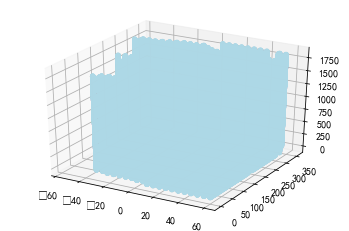

In [164]:
#定义坐标轴
fig4 = plt.figure()
ax4 = plt.axes(projection='3d')

#生成三维数据
X=t300na['lat'].values
Y=t300na['lon'].values
Z=t300na['time'].values

#作图
ax4.scatter(X,Y,Z,c='lightblue' )
#设定显示范围

plt.show()

In [165]:
uana=CMIP6[CMIP6.ua.isna()]

In [166]:
uana

,lat,lon,mode,month,year,sst,t300,ua,va,nino,time
42467,-55.0,0.0,60006,6,37,0.225090,0.104772,NaN,NaN,0.997041,438.0
42575,-55.0,0.0,60006,6,145,-0.031776,-0.084789,NaN,NaN,-2.965493,1734.0
42642,-55.0,0.0,60006,7,61,-0.364984,-0.178408,NaN,NaN,0.196998,727.0
43332,-55.0,0.0,60006,11,147,0.497543,0.481470,NaN,NaN,1.083072,1763.0
44206,-55.0,0.0,60007,5,115,-1.232396,-0.477140,NaN,NaN,-0.942235,1373.0
...,...,...,...,...,...,...,...,...,...,...,...
103323855,60.0,355.0,60013,12,143,-0.517602,-0.502713,NaN,NaN,-0.830871,1716.0
103323856,60.0,355.0,60013,12,144,-0.517083,-0.524053,NaN,NaN,-1.829229,1728.0
103323857,60.0,355.0,60013,12,145,0.033143,0.025727,NaN,NaN,0.400468,1740.0
103323858,60.0,355.0,60013,12,146,-0.519981,-0.523244,NaN,NaN,1.427848,1752.0


In [167]:
uana['va'].value_counts()

Series([], Name: va, dtype: int64)

In [168]:
uana['mode'].value_counts()#60013将近一半 

60013    1189356
60009     943361
60006     898057
60008     837928
60007     771790
Name: mode, dtype: int64

/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


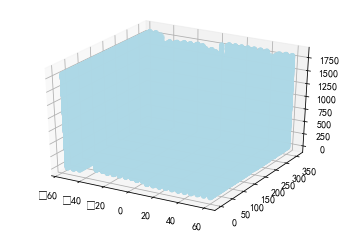

In [169]:
fig4 = plt.figure()
ax4 = plt.axes(projection='3d')
uana60013=uana[uana['mode']==60013]
#生成三维数据
X=uana60013['lat'].values
Y=uana60013['lon'].values
Z=uana60013['time'].values

#作图
ax4.scatter(X,Y,Z,c='lightblue' )
#设定显示范围

plt.show()

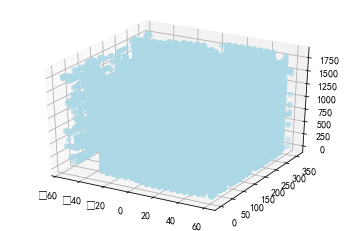

In [173]:
fig4 = plt.figure()
ax4 = plt.axes(projection='3d')
uana60006=uana[uana['mode']==60006]
#生成三维数据
X=uana60006['lat'].values
Y=uana60006['lon'].values
Z=uana60006['time'].values

#作图
ax4.scatter(X,Y,Z,c='lightblue' )
#设定显示范围

plt.show()

In [176]:
uana60006.year.value_counts() #缺898057个数据平均每年缺5998

1      5998
82     5997
91     5993
39     5988
75     5985
       ... 
120    5909
118    5907
9      5907
26     5907
114    5897
Name: year, Length: 151, dtype: int64

In [177]:
uana60006.reset_index()

,index,lat,lon,mode,month,year,sst,t300,ua,va,nino,time
0,42467,-55.0,0.0,60006,6,37,0.225090,0.104772,NaN,NaN,0.997041,438.0
1,42575,-55.0,0.0,60006,6,145,-0.031776,-0.084789,NaN,NaN,-2.965493,1734.0
2,42642,-55.0,0.0,60006,7,61,-0.364984,-0.178408,NaN,NaN,0.196998,727.0
3,43332,-55.0,0.0,60006,11,147,0.497543,0.481470,NaN,NaN,1.083072,1763.0
4,102438,-55.0,5.0,60006,7,61,-0.151699,-0.054758,NaN,NaN,0.196998,727.0
...,...,...,...,...,...,...,...,...,...,...,...,...
898052,103309521,60.0,355.0,60006,2,3,-0.499119,-0.458245,NaN,NaN,-0.857511,26.0
898053,103309533,60.0,355.0,60006,2,15,-0.205219,-0.157428,NaN,NaN,-1.167463,170.0
898054,103309558,60.0,355.0,60006,2,40,-0.202442,-0.180838,NaN,NaN,-0.798864,470.0
898055,103309576,60.0,355.0,60006,2,58,0.175724,0.124024,NaN,NaN,-1.459961,686.0


In [ ]:
train.isna().mean()

In [ ]:
train_sample1=train[train['mode']==50001]
train_sample1[train_sample1.sst.isna()].head()

In [ ]:
#train.iloc[(train.mode()>80).values]加()

In [95]:
train[(train.mode.value>10000)&(train.sst.isna())].head()

AttributeError: 'function' object has no attribute 'value'

## plot

In [ ]:
#bad_air2d[dict(lat=slice(0, 10), lon=slice(0, 25))] = np.nan

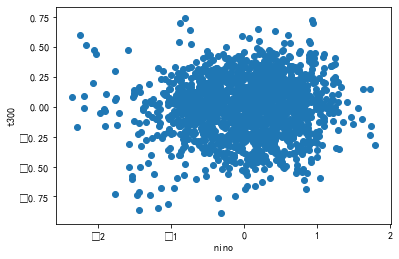

In [187]:
train_data[dict(mode=10,lat=25,lon=0)].plot.scatter(x="nino", y="t300")

/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


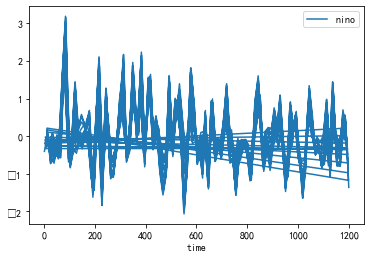

In [213]:
df[(df['mode']==10000)&(df.lat==-55)&(df.lon==355)].plot.line(x="time", y="nino")

/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


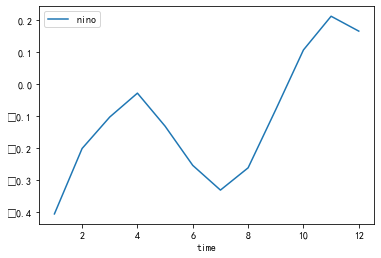

In [214]:
df[(df['mode']==10000)&(df.lat==-55)&(df.lon==355)&(df.year==1)].plot.line(x="time", y="nino")

/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


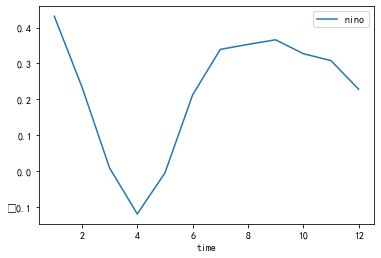

In [226]:
df[(df['mode']==50010)&(df.lat==-55)&(df.lon==355)&(df.year==1)].plot.line(x="time", y="nino")

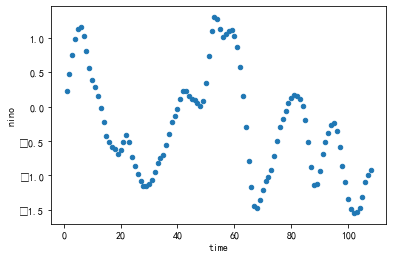

In [227]:
df[(df['mode']==50012)&(df.lat==-55)&(df.lon==355)&(df.year<10)].plot.scatter(x="time", y="nino")

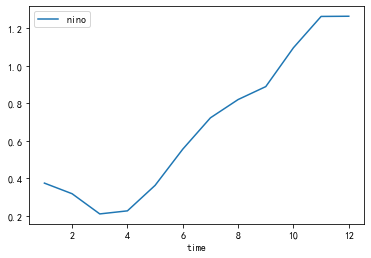

In [221]:
df[(df['mode']==60010)&(df.lat==-55)&(df.lon==355)&(df.year==1)].plot.line(x="time", y="nino")

/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


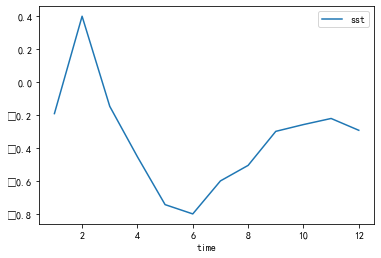

In [222]:
df[(df['mode']==60010)&(df.lat==-55)&(df.lon==355)&(df.year==1)].plot.line(x="time", y="sst")

/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lvzhihao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


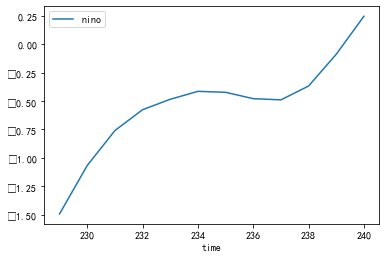

In [218]:
df[(df['mode']==10000)&(df.lat==0)&(df.lon==355)&(df.year==20)].plot.line(x="time", y="nino")